<a href="https://colab.research.google.com/github/josemoragonzalez/ejemplosColab/blob/master/ApiChC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tercer Ejercicio, Api desarrolladores ChC

In [1]:
import pandas as pd
import numpy as np
import requests
import networkx as nx
import matplotlib.pyplot as plt
import time

In [2]:
# Agregar tu ticket
ticket = 'C495FBFD-6480-46C6-8A1A-EAE762EC0271'

In [74]:
# Para efectos de familirizarse con la API, primero hacemos una función simple con la cual obtener un listado de
# todos los compradores 
def compradores(ticket):
  url = 'http://api.mercadopublico.cl/servicios/v1/Publico/Empresas/BuscarComprador?ticket='+ticket
  r = requests.get(url)
  comp_json = r.json()
  df = pd.json_normalize(comp_json['listaEmpresas']) 
  return df

dfcomp = compradores(ticket)
dfcomp

,CodigoEmpresa,NombreEmpresa
0,1034640,CORPORACION MUNICIPAL DE PEÑALOLEN PARA EL DE...
1,7311,Hospital de enfermedades InfecciDr. Lucio Cór...
2,7086,AGCID
3,1224636,Agencia Chilena de Eficiencia Energética
4,7193,Agencia de Promoción de la Inversión Extranjera
...,...,...
856,96996,Universidad de Valparaíso
857,99805,Universidad del Bío-Bío
858,164268,UNIVERSIDAD METROPOLITANA DE CIENCIAS DE LA ED...
859,126109,Universidad Tecnológica Metropolitana


In [5]:
# Entendido lo anterior, usamos la misma lógica para hacer una función que obtenga
# todos los códigos de las OC de una fecha determinada

def ocxfecha(fecha,ticket):
  url = 'http://api.mercadopublico.cl/servicios/v1/publico/ordenesdecompra.json?fecha='+fecha+'&ticket='+ticket
  r = requests.get(url)
  comp_json = r.json()
  df = pd.json_normalize(comp_json['Listado']) 
  return df['Codigo']

In [13]:
dfocs = ocxfecha('01012018', ticket)
len(dfocs)

195

In [7]:
# Definimos una segunda función que nos entregue el detalle de la orden de compra
def ocd(codigo, ticket):
  import time
  time.sleep(2)
  url = 'http://api.mercadopublico.cl/servicios/v1/publico/ordenesdecompra.json?codigo='+codigo+'&ticket='+ticket
  r = requests.get(url)
  comp_json = r.json()
  df = pd.json_normalize(comp_json['Listado']) 
  dfred = df[['Codigo', 'Estado', 'TipoMoneda', 'Total', 'Fechas.FechaEnvio', 'Comprador.NombreOrganismo', 'Proveedor.Nombre']]
  return dfred

In [8]:
dftest = ocd('1057501-6535-SE20', ticket)
dftest

,Codigo,Estado,TipoMoneda,Total,Fechas.FechaEnvio,Comprador.NombreOrganismo,Proveedor.Nombre
0,1057501-6535-SE20,Aceptada,CLP,10017000.0,2020-07-15T17:57:17.413,Complejo Asistencial Dr. Sotero del Rio,CICARSOT S. A.


In [10]:
# Finalmente definimos una tercera función que hace uso de las dos anteriores
# para obtener el detalle de cada una de las órdenes de compra

def oc_fecha_con_detalle(fecha, ticket):
  listoc = ocxfecha(fecha,ticket)
  dfoctotal = pd.DataFrame()
  for oc in listoc:
    dfoctotal = (dfoctotal.append(ocd(oc, ticket)))

  return dfoctotal

In [11]:
# ejecutamos la función para una fecha con pocas OC, ya que la velocidad de ejecución
# es bastante lenta
dfprueba =  oc_fecha_con_detalle('01012020', ticket)
dfprueba

,Codigo,Estado,TipoMoneda,Total,Fechas.FechaEnvio,Comprador.NombreOrganismo,Proveedor.Nombre
0,1057384-402-SE19,Aceptada,CLP,250000.0,2019-12-31T11:32:46.743,Hospital Tocopilla,das ohr
0,1057402-10483-SE19,En proceso,CLP,900000.0,2019-12-12T10:37:23.943,Hospital Dr. Lautaro Navarro Avaria,JOSE LUIS
0,1057402-10756-SE19,Aceptada,CLP,1316467.0,2019-12-31T13:18:35.683,Hospital Dr. Lautaro Navarro Avaria,Carola Andrea
0,1057402-10915-CM19,Aceptada,CLP,2082690.0,2019-12-30T17:25:04.627,Hospital Dr. Lautaro Navarro Avaria,Johnson & Johnson Medical
0,1057402-10997-SE19,Aceptada,CLP,360570.0,2019-12-30T18:19:51.637,Hospital Dr. Lautaro Navarro Avaria,Johnson & Johnson Medical
...,...,...,...,...,...,...,...
0,762514-35-SE19,Aceptada,CLP,710144.0,2019-04-05T15:07:00.26,CAPREDENA,NOVOFARMA SERVICE S A
0,812261-1758-SE19,Aceptada,CLP,5486000.0,2019-12-27T11:51:12.757,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,FastCare SpA
0,879-345-CM19,Aceptada,CLP,128029.0,2019-12-31T21:14:31.933,Instituto Nacional de la Juventud - MIDEPLAN,Sky Airline
0,924-965-SE19,Aceptada,CLP,1957550.0,2019-12-28T11:01:21.193,Subsecretaría de Salud Pública,Climalva Climatizacion Limitada


In [37]:
# Ranking de proveedores
dfmonto_prov = dfprueba.groupby(by=['Proveedor.Nombre'])['Total'].agg(['sum', 'count']).reset_index().sort_values(['sum'], ascending=False).head(10)
dfmonto_prov

,Proveedor.Nombre,sum,count
64,PFIZER CHILE S.A.,3.624853e+09,1
28,GULIETTE GISSETT,3.407500e+08,2
88,cristian andres,1.510214e+08,1
49,MERCK SHARP & DOHME (I. A.) LLC Agencia en Chile,1.150706e+08,9
61,P Y P SERVICIOS E.I.R.L,9.195704e+07,1
53,Marcelo Alejandro,8.180550e+07,5
43,LABORATORIOS ANDROMACO S.A.,3.262854e+07,39
62,PANADERIA DOÑA JAVIERA,2.599898e+07,1
39,Johnson & Johnson Medical,2.539185e+07,6
25,Fernando,2.200000e+07,1


In [38]:
# Ranking de Compradores
dfmonto_comp = dfprueba.groupby(by=['Comprador.NombreOrganismo'])['Total'].agg(['sum', 'count']).reset_index().sort_values(['sum'], ascending=False).head(10)
dfmonto_comp

,Comprador.NombreOrganismo,sum,count
4,Central de Abastecimiento S.N.S.S. - CENABAST,3.624853e+09,1
73,MUNICIPALIDAD DE PUDAHUEL,3.400000e+08,1
12,Gobernación Provincial del Tamarugal,1.510214e+08,1
20,Hospital Dr. GGB,9.743128e+07,7
71,Instituto Nacional del Torax,9.642297e+07,7
58,Ilustre Municipalidad de Litueche,9.195704e+07,1
21,Hospital Dr. Lautaro Navarro Avaria,3.176123e+07,26
9,GOBERNACION PROVINCIAL DE CAUTIN,2.790000e+07,3
8,Ejército de Chile,2.599898e+07,1
90,Universidad de Chile,2.508013e+07,1


In [31]:
# Relación entre comprador y proveedor
dfmonto_prov_comp = dfprueba.groupby(by=['Comprador.NombreOrganismo', 'Proveedor.Nombre'])['Total'].agg(['sum', 'count']).reset_index()
dfmonto_prov_comp

,Comprador.NombreOrganismo,Proveedor.Nombre,sum,count
0,,RADIO TAXI LOS HEROES,100000.0,1
1,ARMADA DE CHILE,INGENIERIA Y SOLUCIONES INFORMATICAS LIMITADA,4740000.0,1
2,ARMADA DE CHILE,LATAM AIRLINES GROUP S.A.,92261.0,1
3,ARMADA DE CHILE,Sky Airline,203168.0,1
4,ARMADA DE CHILE,Sociedad de Transportes Fernandez y Leon Ltda,1762140.0,1
...,...,...,...,...
121,Servicio de Salud del Reloncaví,PRESERVI,8054498.0,1
122,Subsecretaría de Salud Pública,Climalva Climatizacion Limitada,1957550.0,1
123,Superintendencia de Seguridad Social,MARIA JOSEFINA,2800000.0,1
124,Superintendencia de Seguridad Social,Minformatics Spa,760.0,1


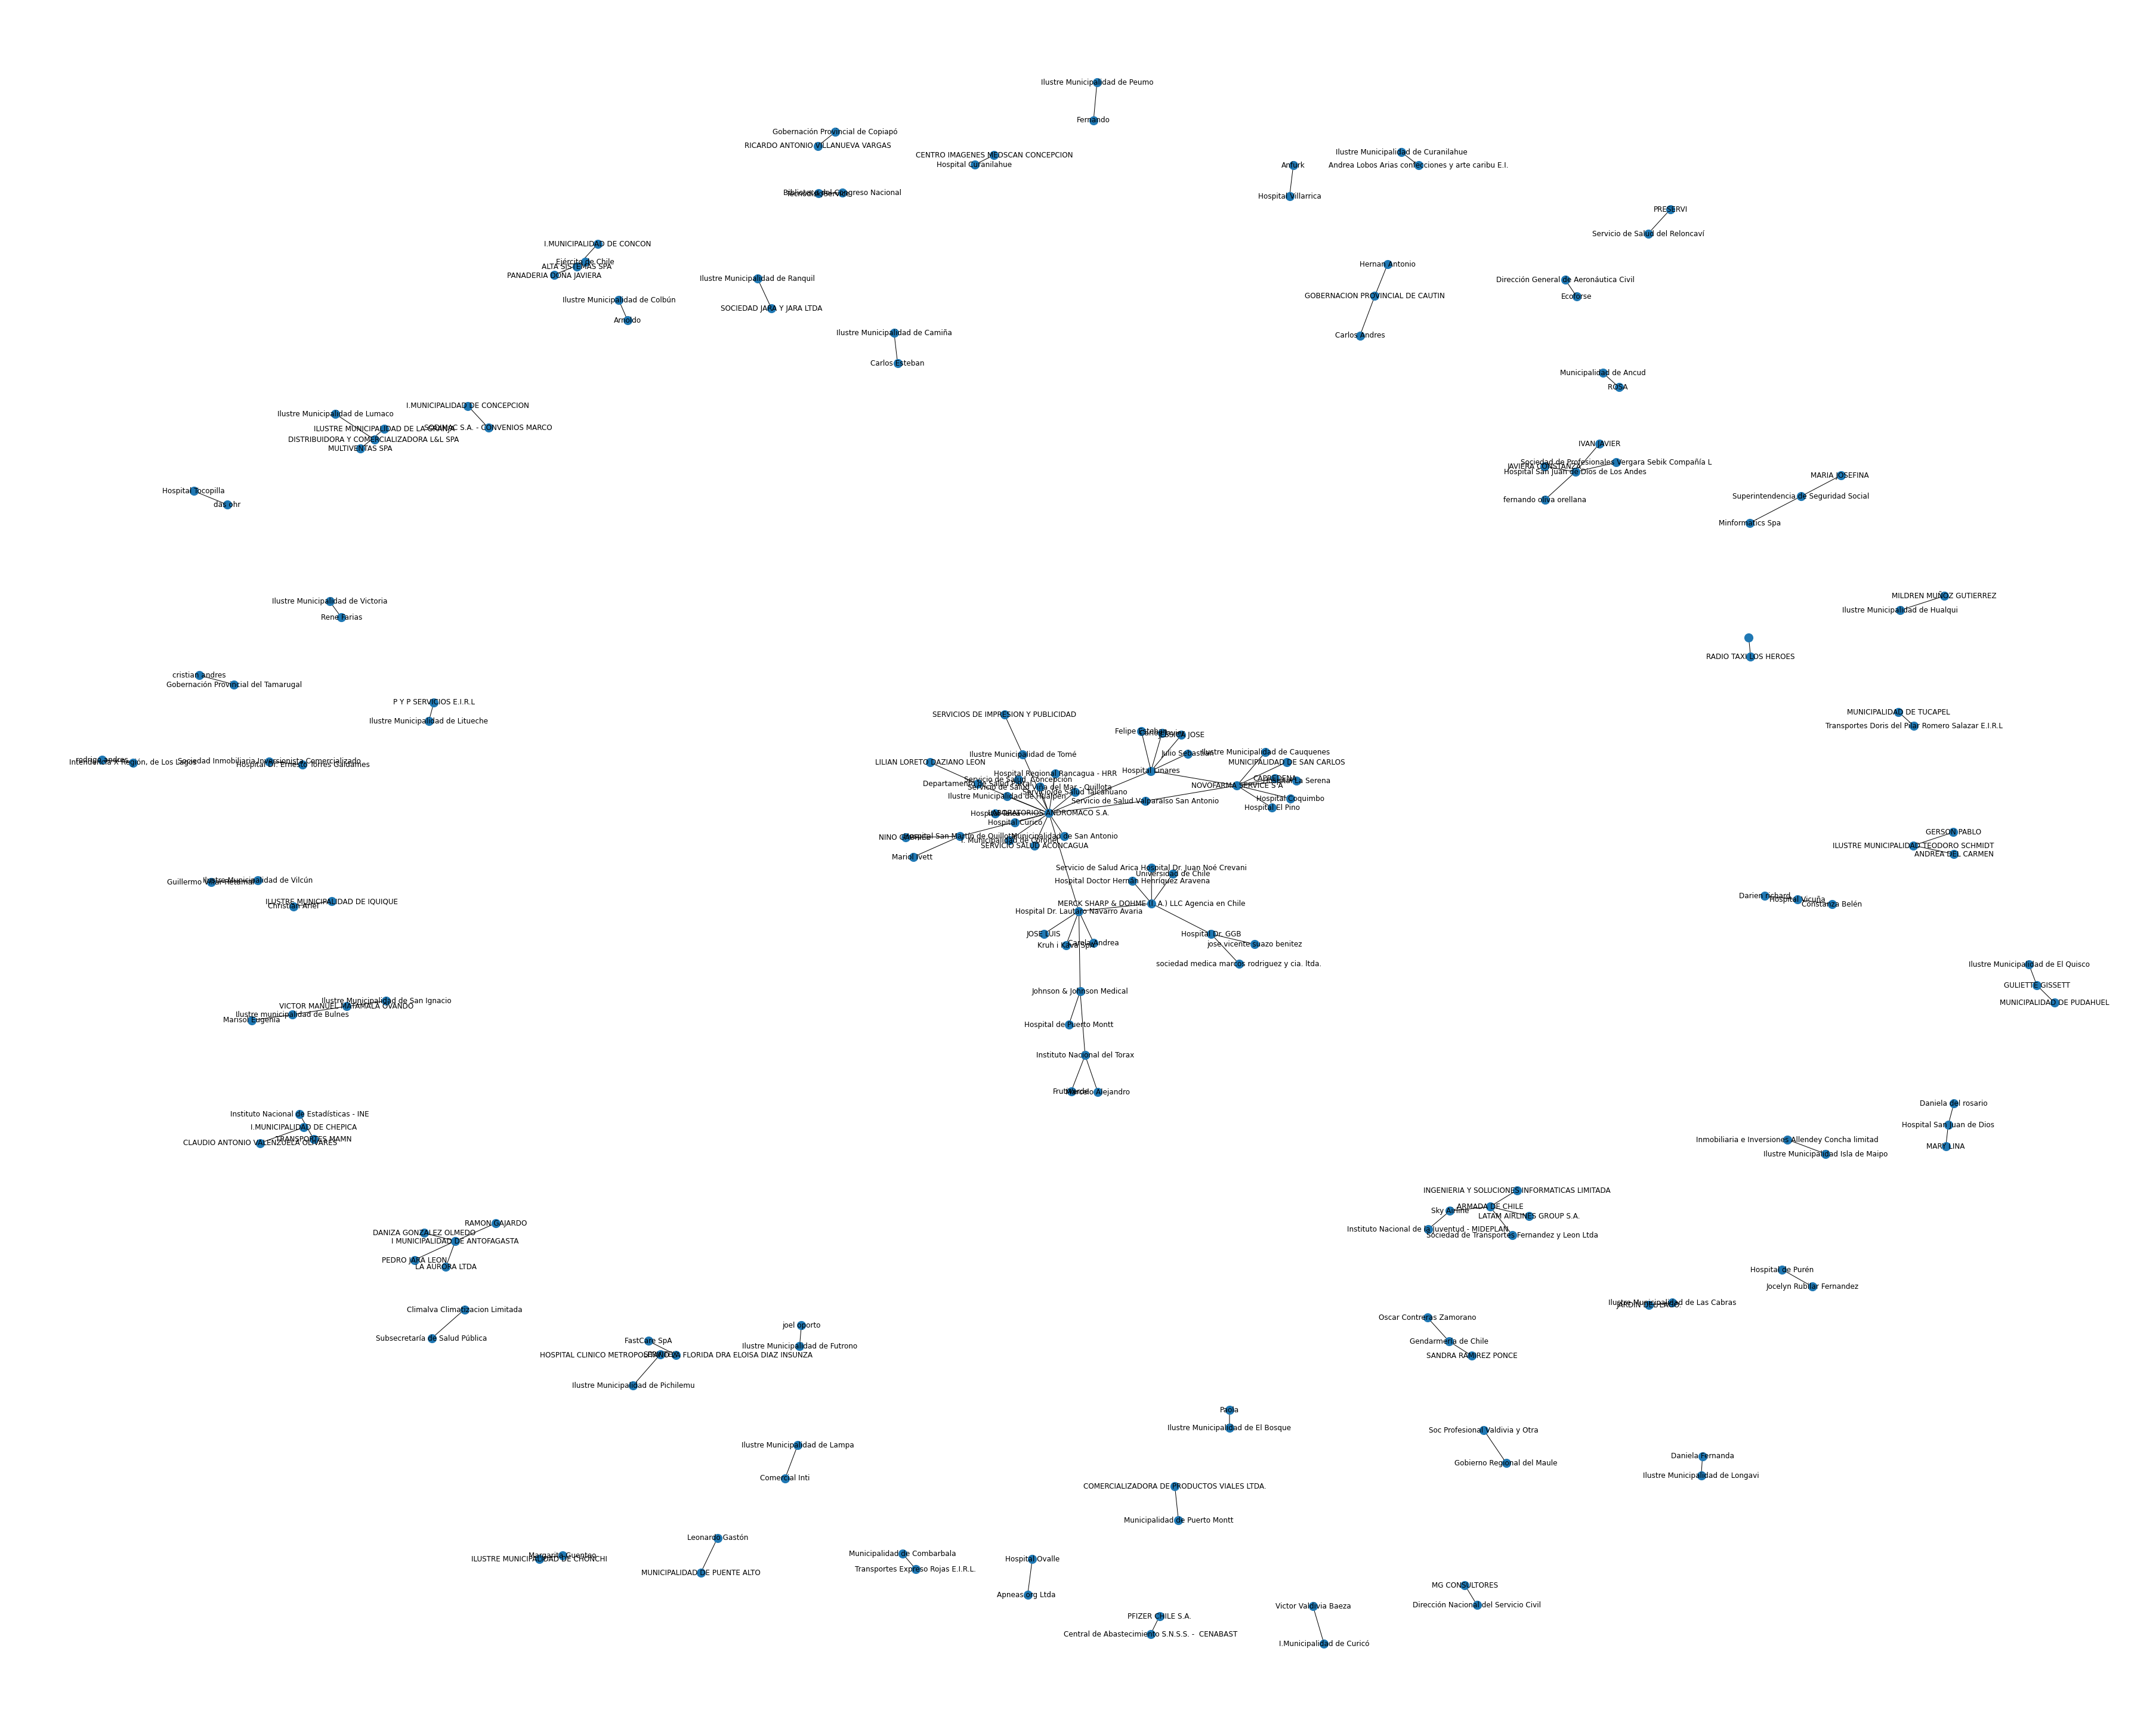

In [72]:
# Hacemos un grafo de las reclaciones
plt.figure(1, figsize=(50,40))

G=nx.from_pandas_edgelist(dfmonto_prov_comp, 'Comprador.NombreOrganismo', 'Proveedor.Nombre', create_using=nx.Graph() )
nx.draw(G, with_labels=True, node_size=200)

plt.show()

In [73]:
dfmonto_prov['Tipo'] = 'Proveedor'
dfmonto_prov = dfmonto_prov.rename(columns={'Proveedor.Nombre':'Nodo'})
dfmonto_comp['Tipo'] = 'Comprador'
dfmonto_comp = dfmonto_comp.rename(columns={'Comprador.NombreOrganismo':'Nodo'})
dfnodos = dfmonto_comp.append(dfmonto_prov)